In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu117'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# what we are trying to *learn* this will be the equation of a line where weight defines a slope and bias kind of represents the y intercept
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

#X is the set of features and y are labels
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
# Splitting the dataset into train and test sets
train_split_length = int(0.8 * len(X)) #80 is training data
X_train, y_train = X[:train_split_length], y[:train_split_length]
X_test, y_test = X[train_split_length:], y[train_split_length:]
# X_train.to(device)
# y_train.to(device)
# X_test.to(device)
# y_test.to(device)

len(X_train), len(X_test)

(40, 10)

In [6]:
def plot_predictions(
train_data = X_train,
train_labels = y_train,
test_data = X_test,
test_labels = y_test,
predictions = None):
    plt.figure(figsize=(10,7))
    
    plt.scatter(train_data, train_labels, color="blue", s=4, label="Training data")
    
    plt.scatter(test_data, test_labels, color="green", s=4, label="Test data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, color="red", s=4, label="Predictions")
        
    plt.legend(prop={"size": 14})


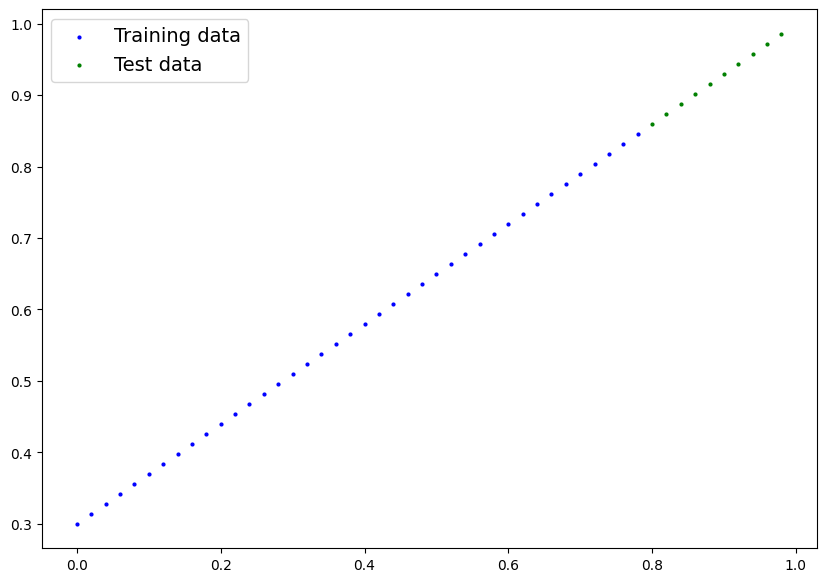

In [7]:
plot_predictions()

In [8]:
# We are attempting to only *teach* one node in a model, one node can only define a function that is linear hence linear regression
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(
        1, # starting with a random weight
        dtype = torch.float, # override the default float32(?) you can remove this , it's just for accuracy
        requires_grad = True # can we update this value with gradient descent?
        ))
        
        self.bias = nn.Parameter(torch.randn(
        1, # start with a random bias
        dtype = torch.float, # same as above
        requires_grad = True # same as above
        ))
        
    # forward should define how the model computes (in each pass), the models starts with random weight and bias then we receive a tensor and adjust it accordingly using this forward function
    # note that the function below is wrapoped by a wrapper which probably controls how much self.weights and self.bias learns using gradient descent. (unverified inference)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you must write an override for the forward method
* torch.optim - this is where the optimizers in PyTorch live which is used for gradient descent (how the gradient descent works)
* def forward() - all nn.Module subclasses must define this override function, it defines what happens in the forward computation a.k.a. forward pass.

In [9]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())
# Or you can use
#model_0.state_dict()

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# model_0.to(device)

In [11]:
# checking if on cuda
next(model_0.parameters()).is_cuda

False

In [12]:
# Making predictions with the model - this uses the model not trains it, so we can perhaps check progress or use the model for our actual purpose
with torch.inference_mode():
    y_preds = model_0(X_test)

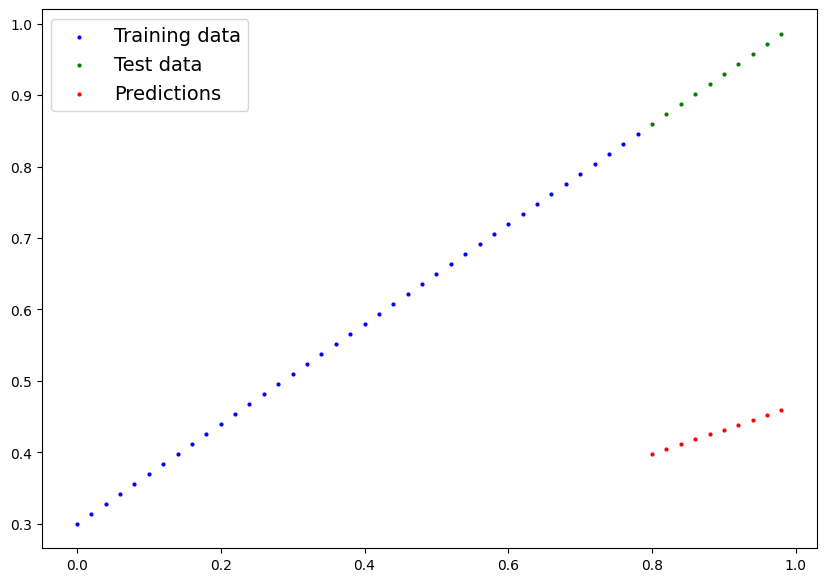

In [13]:
plot_predictions(predictions = y_preds)

### Training the model
* define a loss function which measures how "off" we are from the actual values we want, the one used below is MAE or Mean Absolute Error which simply takes the mean of the differences of the predicted values from the actual test values

* define an optimizer function probably from torch.optim which will also define how we optimize/change the values of the tensors and how fast (learning rate) we change them per epoch

In [14]:
# Create the loss function
# loss_fn = nn.L1Loss() # MAE loss is same as L1Loss
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### The PyTorch training loop

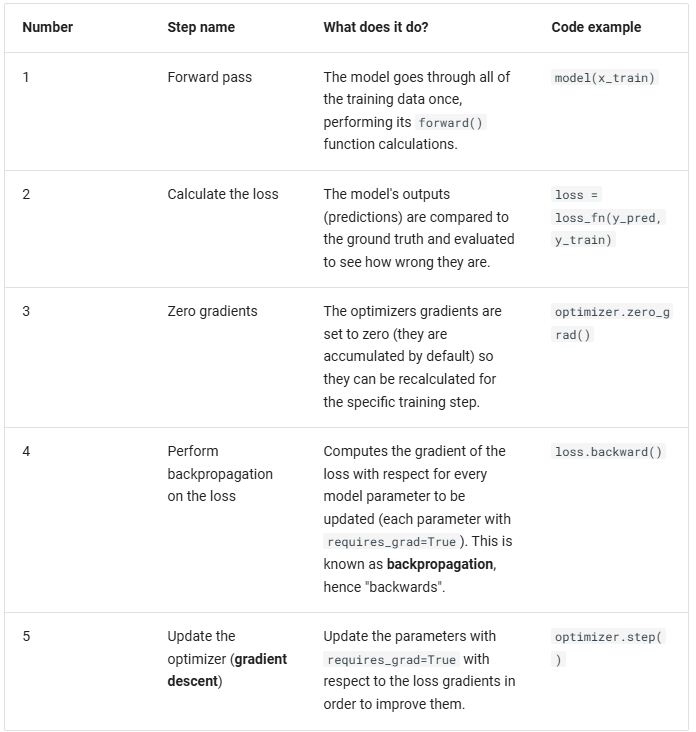

The rules above are not fixed, the training loop can be flexible but there are some rules of thumb...

On the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:

* Calculate the loss (loss = ...) before performing backpropagation on it (loss.backward()).
* Zero gradients (optimizer.zero_grad()) before computing the gradients of the loss with respect to every model parameter (loss.backward()).
* Step the optimizer (optimizer.step()) after performing backpropagation on the loss (loss.backward()).

In [15]:
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


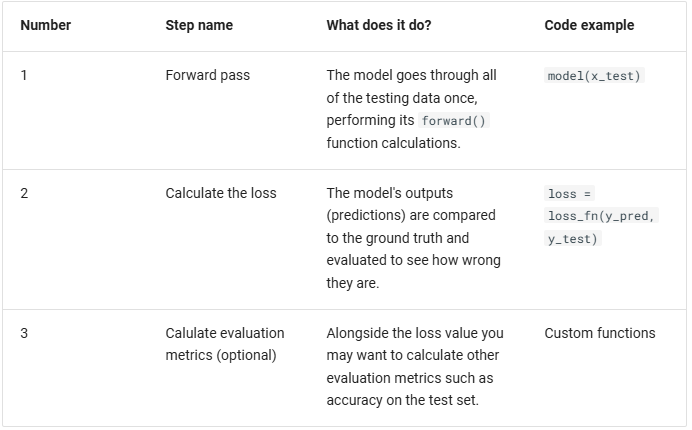

In [16]:
# Making predictions with the model - this uses the model not trains it, so we can perhaps check progress or use the model for our actual purpose
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
    
model_0.weights, model_0.bias

(Parameter containing:
 tensor([0.5784], requires_grad=True),
 Parameter containing:
 tensor([0.3513], requires_grad=True))

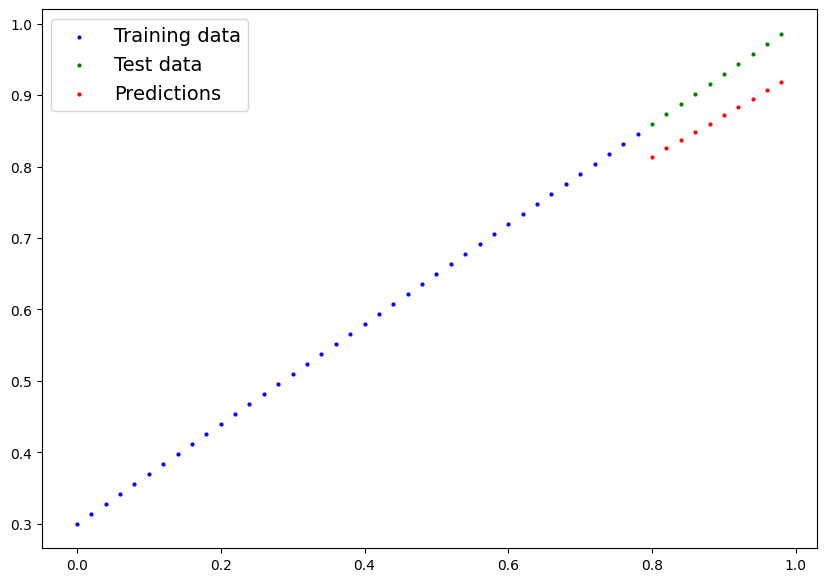

In [17]:
plot_predictions(predictions = y_preds)

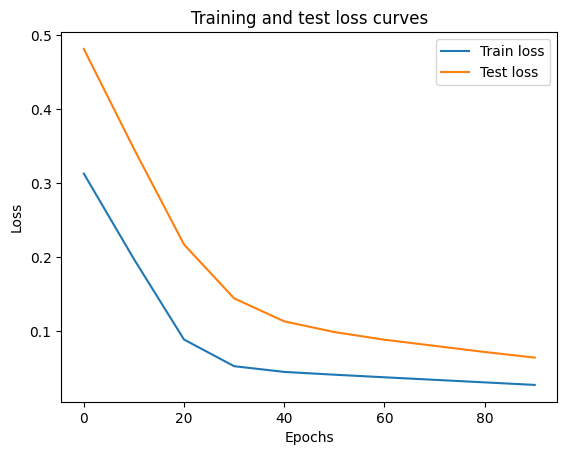

In [18]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Saving and Loading models

In [19]:
# Saving models
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_learnpytorch.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_learnpytorch.pth


In [20]:
#Loading models
#Instantiate Base class of the model first
loaded_model = LinearRegressionModel()

#Load the state_dict of the saved model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
# using the loaded model again
loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## SUMMARY AND SYNTHESIS


#### Setting the code to be device agnostic, seeding pytorch

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

print(f"Target device is {device}.")

Target device is cuda.


#### Creating the test and training data

In [44]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # adding 1 dimension for shape purposes since it is likely that pytorch accepts "vertical"ly printed tensors instead of them being in one dimension like a list
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### Splitting the data into training and testing sets

In [45]:
train_len = int(len(X) * 0.8)
X_train = X[:train_len]
y_train = y[:train_len]
X_test = X[train_len:]
y_test = y[train_len:]

len(X_train), len(X_test)

(40, 10)

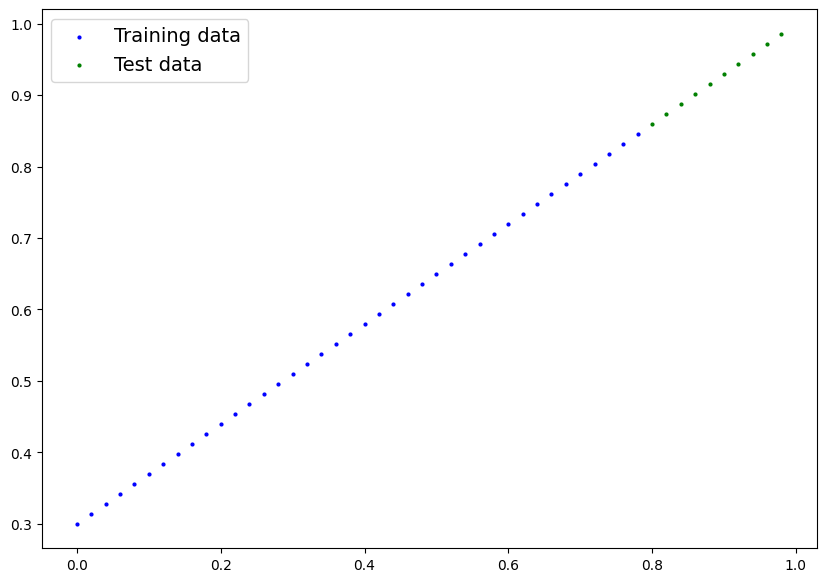

In [46]:
plot_predictions(X_train, y_train, X_test, y_test)

#### Building a PyTorch Linear Model

nn.Linear will be used instead of defining specific parameters.

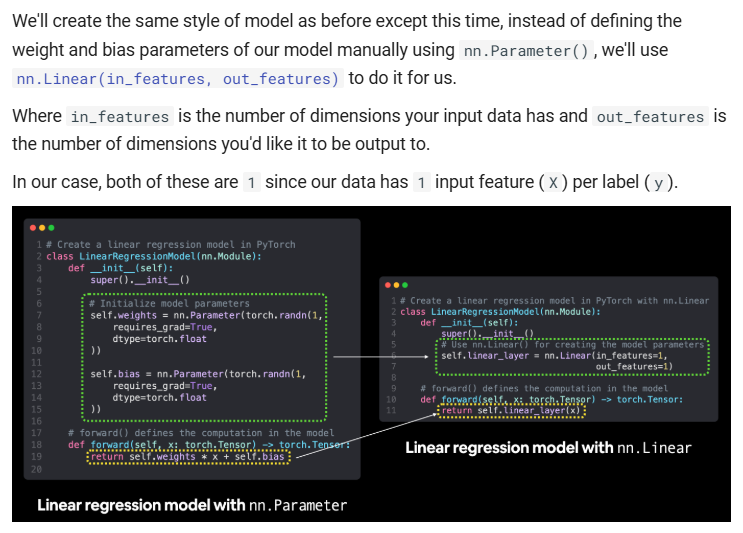

In [47]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # This will create 1 node with both a weight and bias which we had to define using two definitions of parameters in LinearRegressionModel version 1.
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
model_1 = LinearRegressionModelV2()
model_1.to(device)

print(f"model_1 is loaded on device: {next(model_1.parameters()).device}")

model_1.state_dict()


model_1 is loaded on device: cuda:0


OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

#### Setting a loss function and optimizer

In [ ]:
# Setting the Loss function to MAE (again)
loss_fn = nn.L1Loss()

# Setting the optimizer to SGD (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_1.parameters(), #optimize the newly created model's parameters
                             lr=0.001) 

#### Loading the data to the available device and running the training loop

In [ ]:
torch.manual_seed(42)

epochs = 10000

# NOTE: Tensor.to(device) is pass by value! it returns a new object and is not in place!
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # Setting to train mode (default after instantiation(?), in case we predicted and decided to run this again)

    # 1. Forward pass
    y_pred = model_1.forward(X_train) # This should be model_1(X_train) but I think this will result in the same

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer - zero the optimizer gradients
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_1(X_test)

        # 2. Calculate Loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
    

Epoch: 0 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 100 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 200 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 300 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 400 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 500 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 600 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 700 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 800 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 900 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 1000 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 1100 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 1200 | Tr

In [65]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


#### Making predictions

In [60]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]], device='cuda:0')

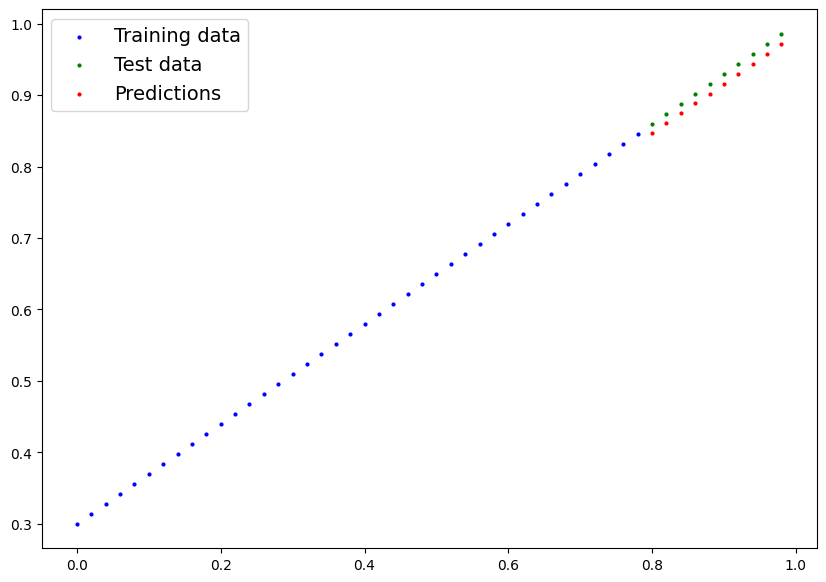

In [61]:


plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())